<a href="https://colab.research.google.com/github/Ravi-kjain84/Articles/blob/main/22_Using_machine_learning_for_detecting_liquidity_risk_in_banks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
import yfinance as yf
import requests
import io
import tensorflow as tf
from sklearn.impute import SimpleImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Suppress TensorFlow warnings
tf.get_logger().setLevel('ERROR')


In [2]:
# Function to fetch data from Yahoo Finance
def fetch_yahoo_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    data.reset_index(inplace=True)
    return data

# Fetching example data
nasdaq100 = fetch_yahoo_data('^NDX', '2007-01-01', '2021-12-31')
vix = fetch_yahoo_data('^VIX', '2007-01-01', '2021-12-31')
crude_oil = fetch_yahoo_data('CL=F', '2007-01-01', '2021-12-31')

# Function to fetch data from FRED
def fetch_fred_data(series_id, start_date, end_date):
    url = f"https://fred.stlouisfed.org/graph/fredgraph.csv?id={series_id}&cosd={start_date}&coed={end_date}"
    s = requests.get(url).content
    df = pd.read_csv(io.StringIO(s.decode('utf-8')))
    return df

# Fetching example data
ted_spread = fetch_fred_data('TEDRATE', '2007-01-01', '2021-12-31')


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
# Example preprocessing for NASDAQ 100 data
nasdaq100['Log_Return'] = np.log(nasdaq100['Close'] / nasdaq100['Close'].shift(1))
nasdaq100['7d_Stdev'] = nasdaq100['Log_Return'].rolling(window=7).std()

# Example preprocessing for VIX data
vix['Log_Return'] = np.log(vix['Close'] / vix['Close'].shift(1))
vix['7d_Stdev'] = vix['Log_Return'].rolling(window=7).std()

# Merging datasets
merged_data = nasdaq100[['Date', 'Log_Return', '7d_Stdev']].rename(columns={'Log_Return': 'NASDAQ_Log_Return', '7d_Stdev': 'NASDAQ_7d_Stdev'})
merged_data = merged_data.merge(vix[['Date', 'Log_Return', '7d_Stdev']].rename(columns={'Log_Return': 'VIX_Log_Return', '7d_Stdev': 'VIX_7d_Stdev'}), on='Date', how='inner')


In [9]:
# Define features and target
features = ['NASDAQ_Log_Return', 'NASDAQ_7d_Stdev', 'VIX_Log_Return', 'VIX_7d_Stdev']
target = 'STLFSI'  # Example target variable, replace with actual target data

# Load or simulate target data
# For demonstration purposes, generate random target data
np.random.seed(42)
merged_data['STLFSI'] = np.random.choice([0, 1], size=len(merged_data))

# Split data into training and testing sets
X = merged_data[features]
y = merged_data[target]

# Impute missing values
imputer = SimpleImputer(strategy='mean')  # You can also use 'median', 'most_frequent', or 'constant'
X_imputed = imputer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.33, random_state=42)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Evaluate Random Forest Model
print("\nRandom Forest Model Accuracy:", accuracy_score(y_test, rf_predictions))
print("\nClassification Report:")
print(classification_report(y_test, rf_predictions))

# Train Neural Network for Classification
mlp_model = Sequential()
mlp_model.add(Dense(64, input_dim=len(features), activation='relu'))
mlp_model.add(Dense(32, activation='relu'))
mlp_model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification

mlp_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the MLP model
mlp_model.fit(X_train, y_train, epochs=100, batch_size=10)

# Evaluate the MLP model
mlp_loss, mlp_accuracy = mlp_model.evaluate(X_test, y_test)
print("\nMLP Model Accuracy:", mlp_accuracy)



Random Forest Model Accuracy: 0.5108259823576584

Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.51      0.51       632
           1       0.50      0.51      0.51       615

    accuracy                           0.51      1247
   macro avg       0.51      0.51      0.51      1247
weighted avg       0.51      0.51      0.51      1247

Epoch 1/100
253/253 [==============================] - 2s 4ms/step - loss: 0.6935 - accuracy: 0.4879
Epoch 2/100
253/253 [==============================] - 1s 4ms/step - loss: 0.6935 - accuracy: 0.4951
Epoch 3/100
253/253 [==============================] - 1s 2ms/step - loss: 0.6934 - accuracy: 0.5061
Epoch 4/100
253/253 [==============================] - 1s 2ms/step - loss: 0.6934 - accuracy: 0.4840
Epoch 5/100
253/253 [==============================] - 1s 2ms/step - loss: 0.6932 - accuracy: 0.5045
Epoch 6/100
253/253 [==============================] - 1s 3ms/step - loss: 0.6933 - accuracy: 

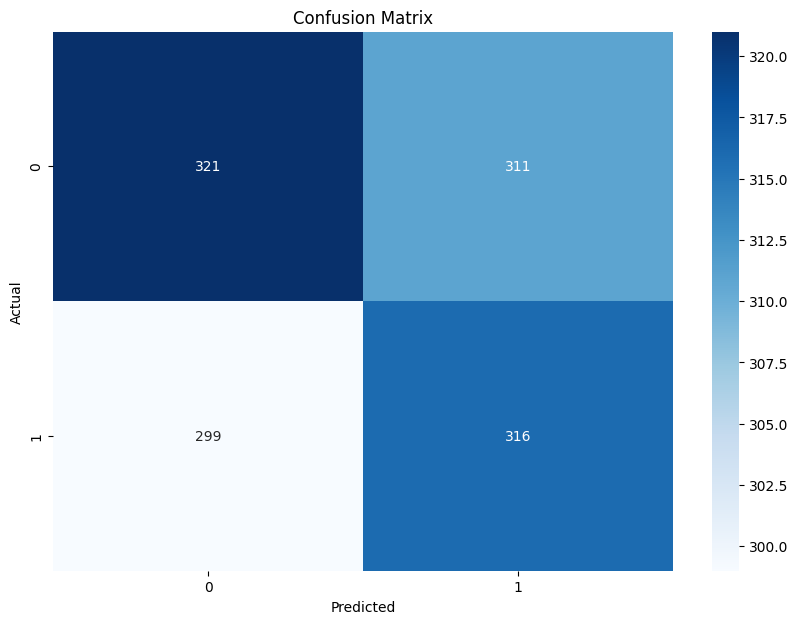

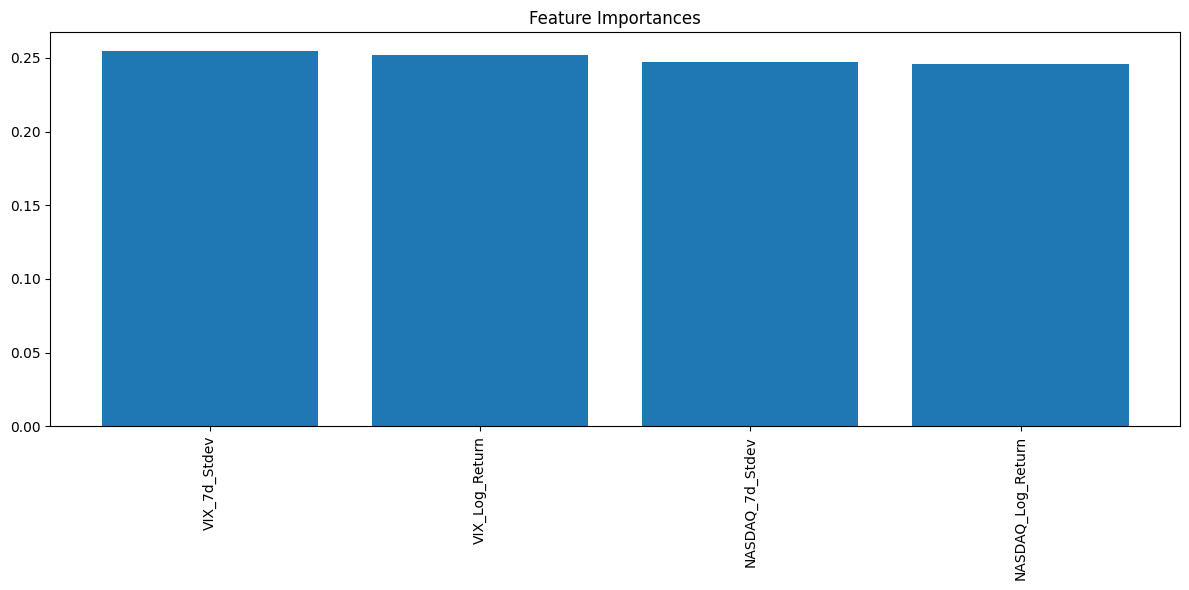

In [10]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, rf_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature Importance
feature_importances = rf_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), feature_importances[indices], align='center')
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


In [11]:
# Display evaluation metrics and discuss the results
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_r2 = r2_score(y_test, rf_predictions)

print("\nRandom Forest Model Mean Absolute Error:", rf_mae)
print("\nRandom Forest Model Root Mean Squared Error:", rf_rmse)
print("\nRandom Forest Model R^2 Score:", rf_r2)

# Display results for the neural network model
mlp_predictions = mlp_model.predict(X_test)
mlp_rmse = np.sqrt(mean_squared_error(y_test, mlp_predictions))
mlp_r2 = r2_score(y_test, mlp_predictions)

print("\nMLP Model Root Mean Squared Error:", mlp_rmse)
print("\nMLP Model R^2 Score:", mlp_r2)



Random Forest Model Mean Absolute Error: 0.48917401764234164

Random Forest Model Root Mean Squared Error: 0.6994097637596587

Random Forest Model R^2 Score: -0.9570597921169084
39/39 [==============================] - 0s 1ms/step

MLP Model Root Mean Squared Error: 0.5003501003109757

MLP Model R^2 Score: -0.0015870374917088537
